In [1]:
from ultralytics import YOLO
import os, shutil, random
from pathlib import Path
import numpy as np
import cv2
from lxml import etree
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:

#%% initiale data dirs
dogs_root = Path("Dogbreeds")  #path to dataset
images_src = dogs_root / "images" / "Images" #path to images
ann_src    = dogs_root / "annotations" / "Annotation" #path to annotations
print(f"Images path: {images_src}")
print(f"Annotations path: {ann_src}")
assert images_src.exists() and ann_src.exists(), "Couldn't find Images/ and Annotation/ under dogs_root" #check if paths exist
# %% get class names



Images path: Dogbreeds/images/Images
Annotations path: Dogbreeds/annotations/Annotation


In [3]:
img_dirs = [d for d in os.listdir(images_src) if d != '.DS_Store']
# parse breed names and build multiple mappings: full folder, wnid (n020...), and breed name
breed_entries = []
for d in img_dirs:
    parts = d.split('-')
    wnid = parts[0]
    breed = parts[1] if len(parts) > 1 else d
    breed_entries.append((d, wnid, breed))
breed_entries = sorted(breed_entries, key=lambda x: x[2])  # sort by breed name
breed_names = [b for (_, _, b) in breed_entries]
print(breed_names)

# mappings for different possible name formats found in XML
full_dir_to_id = {}
wnid_to_id = {}
breedname_to_id = {}
for idx, (full, wnid, breed) in enumerate(breed_entries):
    full_dir_to_id[full] = idx
    wnid_to_id[wnid] = idx
    breedname_to_id[breed] = idx
print("Mappings sample:", list(breedname_to_id.items())[:5])

def get_class_id(xml_name):
    """Return class id for xml_name trying different formats."""
    if xml_name in breedname_to_id:
        return breedname_to_id[xml_name]
    if xml_name in wnid_to_id:
        return wnid_to_id[xml_name]
    if xml_name in full_dir_to_id:
        return full_dir_to_id[xml_name]
    # try splitting cases like "n02085620-Chihuahua"
    if '-' in xml_name:
        parts = xml_name.split('-')
        # try last part (breed)
        if parts[-1] in breedname_to_id:
            return breedname_to_id[parts[-1]]
        # try first part (wnid)
        if parts[0] in wnid_to_id:
            return wnid_to_id[parts[0]]
    return None



['Afghan_hound', 'African_hunting_dog', 'Airedale', 'American_Staffordshire_terrier', 'Appenzeller', 'Australian_terrier', 'Bedlington_terrier', 'Bernese_mountain_dog', 'Blenheim_spaniel', 'Border_collie', 'Border_terrier', 'Boston_bull', 'Bouvier_des_Flandres', 'Brabancon_griffon', 'Brittany_spaniel', 'Cardigan', 'Chesapeake_Bay_retriever', 'Chihuahua', 'Dandie_Dinmont', 'Doberman', 'English_foxhound', 'English_setter', 'English_springer', 'EntleBucher', 'Eskimo_dog', 'French_bulldog', 'German_shepherd', 'German_short', 'Gordon_setter', 'Great_Dane', 'Great_Pyrenees', 'Greater_Swiss_Mountain_dog', 'Ibizan_hound', 'Irish_setter', 'Irish_terrier', 'Irish_water_spaniel', 'Irish_wolfhound', 'Italian_greyhound', 'Japanese_spaniel', 'Kerry_blue_terrier', 'Labrador_retriever', 'Lakeland_terrier', 'Leonberg', 'Lhasa', 'Maltese_dog', 'Mexican_hairless', 'Newfoundland', 'Norfolk_terrier', 'Norwegian_elkhound', 'Norwich_terrier', 'Old_English_sheepdog', 'Pekinese', 'Pembroke', 'Pomeranian', 'Rho

In [4]:
# %% create output directories
out_root = Path("dogs_yolo_dataset") #output root directory
train_img_dir = out_root /"Images"/"train"
val_img_dir = out_root /"Images"/"val"

train_label_dir = out_root /"labels"/"train"
val_label_dir = out_root /"labels"/"val"

train_img_dir.mkdir(parents=True, exist_ok=True)
val_img_dir.mkdir(parents=True, exist_ok=True)
train_label_dir.mkdir(parents=True, exist_ok=True)
val_label_dir.mkdir(parents=True, exist_ok=True)



In [5]:
# %% helper functions to convert xml to yolo bounding box
def coord_to_yolo_bbox(xmin, ymin, xmax,ymax, w, h):
    width_x = xmax - xmin
    width_y = ymax - ymin
    cx_bb = xmin + width_x/2
    cy_bb = ymin + width_y/2
    
    #normalize with w and h of image
    cx_bb =cx_bb/w
    cy_bb  = cy_bb/h
    
    
    width_x =width_x/w
    width_y = width_y/h
    
    
    return cx_bb, cy_bb, width_x, width_y



In [6]:
#%% test script for accesing xml file
#test path
xml_path = r'/Users/ememusoh/Desktop/workflow_yolo/Dogbreeds/annotations/Annotation/n02085620-Chihuahua/n02085620_7.xml'
tree = etree.parse(str(xml_path))
root = tree.getroot()

source = root.find('source')
database = source.findtext('database')



In [7]:
# %% helper function for accessing xml file to get yolo coordinates

def parse_xml_coordiantes(xml_path):
    tree = etree.parse(str(xml_path))
    root = tree.getroot()
    
    size = root.find("size")
    w = int(size.findtext("width")) 
    h = int(size.findtext("height"))
    
    # Collect all objects in this XML file. Each object is a list:
    # [name, xmin, ymin, xmax, ymax, image_width, image_height]
    xml_objects = []

    for obj in root.findall('object'):
        name = obj.findtext('name')
        bnd = obj.find("bndbox")
        xmin = float(bnd.findtext("xmin"))
        ymin = float(bnd.findtext("ymin"))
        xmax = float(bnd.findtext("xmax"))
        ymax = float(bnd.findtext("ymax"))

        xml_objects.append([name, xmin, ymin, xmax, ymax, w, h])

    # Return the list of objects (may be empty if no objects found)
    return xml_objects
    
xml_objects =   parse_xml_coordiantes(xml_path)
print(xml_objects) 


# name, xmin, ymin, xmax, ymax, w, h = xml_objects[0]
# cx_bb, cy_bb, width_x, width_y = coord_to_yolo_bbox(xmin, ymin, xmax,ymax, w, h)

# print(cx_bb, cy_bb, width_x, width_y)

for name, xmin, ymin, xmax, ymax, w, h in xml_objects:
    cx_bb, cy_bb, width_x, width_y = coord_to_yolo_bbox(xmin, ymin, xmax,ymax, w, h)
    print(f"Object: {name}, YOLO bbox: {cx_bb}, {cy_bb}, {width_x}, {width_y}")


[['Chihuahua', 71.0, 1.0, 192.0, 180.0, 250, 188]]
Object: Chihuahua, YOLO bbox: 0.526, 0.48138297872340424, 0.484, 0.9521276595744681


In [8]:
# %% get all annotation label from our dataset 
#ann_src
#get the  img_path, xml_path
IMGS_PATH_LS = []
XML_PATH_LS = []
annotation_dir_list = [d for d in os.listdir(ann_src) if d != '.DS_Store']
annotation_dir_list.sort(key=lambda i: i.split('-')[1] if '-' in i else i)

img_dir_list = [d for d in os.listdir(images_src) if d != '.DS_Store']
img_dir_list.sort(key=lambda i: i.split('-')[1] if '-' in i else i)

assert len(img_dir_list) == len(annotation_dir_list)


annotation_dir_list_filepath = []
image_dir_list_filepath = []
for (anno_breedname, img_breedname) in zip(annotation_dir_list,img_dir_list):
    annotation_dir_list_filepath.append(os.path.join(ann_src, anno_breedname)) #make file path to dog breed dir
    image_dir_list_filepath.append(os.path.join(images_src, img_breedname))

#get each xml path and also check for image exist in the image folder
for (anno_breedname_dir_filepath, img_breedname_dir_filepath) in zip(annotation_dir_list_filepath, image_dir_list_filepath):
    print(f'anno_breedname_dir_path:{anno_breedname_dir_filepath}')
    print(f'image_breedname_dir_path:{img_breedname_dir_filepath}')
    anno_xml_files = os.listdir(anno_breedname_dir_filepath)
    anno_xml_files.sort(key=lambda i:int(i.split("_")[1].split('.')[0]))
    imgs_src_files = os.listdir(img_breedname_dir_filepath)
    imgs_src_files.sort(key=lambda i:int(i.split("_")[1].split('.')[0]))
    
    
    #go in through each dir to add filename to path, then access the details
    for (xml_filename, img_filename) in zip(anno_xml_files, imgs_src_files):
        xml_path = Path(os.path.join(anno_breedname_dir_filepath, xml_filename))
        img_filepath = Path(os.path.join(img_breedname_dir_filepath, img_filename))
        
        # print(f'xml_path: {xml_path}')
        # print(f'img_filepath: {img_filepath}')
        
        #check if image file path exist, and annotation file path exist
        #check if image can be opened
        #check if xml can be accessed
        #if it fails, continue
        
        if img_filepath.exists() and xml_path.exists():
            #check if image can be opened and xml can be accessed
            try:
                img = cv2.imread(str(img_filepath))
                tree = etree.parse(str(xml_path))
                root = tree.getroot()
                if img is None or tree is None:
                    print(f"Warning: Unable to open image file {img_filepath}. Skipping this file.")
                    continue
            except Exception as e:
                print(f"Error opening image file {img_filepath}: {e}. Skipping this file.")
                print(f"Error opening XML file {xml_path}: {e}. Skipping this file.")
                continue
            #getting xml details
            IMGS_PATH_LS.append(img_filepath)
            XML_PATH_LS.append(xml_path)
print(f'length_of_img_path:{len(IMGS_PATH_LS)}')
print(f'length_of_xml_path:{len(XML_PATH_LS)}')





anno_breedname_dir_path:Dogbreeds/annotations/Annotation/n02088094-Afghan_hound
image_breedname_dir_path:Dogbreeds/images/Images/n02088094-Afghan_hound
anno_breedname_dir_path:Dogbreeds/annotations/Annotation/n02116738-African_hunting_dog
image_breedname_dir_path:Dogbreeds/images/Images/n02116738-African_hunting_dog
anno_breedname_dir_path:Dogbreeds/annotations/Annotation/n02096051-Airedale
image_breedname_dir_path:Dogbreeds/images/Images/n02096051-Airedale
anno_breedname_dir_path:Dogbreeds/annotations/Annotation/n02093428-American_Staffordshire_terrier
image_breedname_dir_path:Dogbreeds/images/Images/n02093428-American_Staffordshire_terrier
anno_breedname_dir_path:Dogbreeds/annotations/Annotation/n02107908-Appenzeller
image_breedname_dir_path:Dogbreeds/images/Images/n02107908-Appenzeller
anno_breedname_dir_path:Dogbreeds/annotations/Annotation/n02096294-Australian_terrier
image_breedname_dir_path:Dogbreeds/images/Images/n02096294-Australian_terrier
anno_breedname_dir_path:Dogbreeds/an

In [9]:
#%%perform EDA on the dataset
# Build a table of all annotated objects and compute statistics + plots.
sns.set(style="whitegrid", rc={"figure.figsize": (8, 5)})

eda_out = out_root / "eda"
eda_out.mkdir(parents=True, exist_ok=True)

# Build rows: one row per object in dataset
rows = []
for img_path, xml_path in tqdm(list(zip(IMGS_PATH_LS, XML_PATH_LS)), desc="Parsing XMLs"):
    try:
        objs = parse_xml_coordiantes(xml_path)
    except Exception as e:
        print(f"Failed to parse {xml_path}: {e}")
        continue
    # If no objects, still register the image (optional)
    if len(objs) == 0:
        rows.append({
            "image_path": str(img_path),
            "xml_path": str(xml_path),
            "class_name": None,
            "class_id": None,
            "xmin": None, "ymin": None, "xmax": None, "ymax": None,
            "img_w": None, "img_h": None,
            "bbox_w": None, "bbox_h": None,
            "bbox_area": None, "bbox_area_norm": None, "bbox_ar": None
        })
        continue

    for name, xmin, ymin, xmax, ymax, w, h in objs:
        cid = get_class_id(name)
        bw = xmax - xmin
        bh = ymax - ymin
        area = bw * bh
        norm_area = area / (w * h) if (w * h) > 0 else None
        ar = (bw / bh) if bh > 0 else None
        rows.append({
            "image_path": str(img_path),
            "xml_path": str(xml_path),
            "class_name": name,
            "class_id": cid,
            "xmin": xmin, "ymin": ymin, "xmax": xmax, "ymax": ymax,
            "img_w": w, "img_h": h,
            "bbox_w": bw, "bbox_h": bh,
            "bbox_area": area, "bbox_area_norm": norm_area, "bbox_ar": ar
        })

df = pd.DataFrame(rows)


Parsing XMLs: 100%|██████████| 20580/20580 [00:00<00:00, 22286.52it/s]


In [10]:
# Basic dataset counts
num_images = len(df["image_path"].unique())
num_annotations = df["class_name"].notna().sum()
num_classes = len(breed_names)
print(f"Images: {num_images}, Annotated objects: {num_annotations}, Classes (declared): {num_classes}")



Images: 20580, Annotated objects: 22126, Classes (declared): 120


In [11]:
# Class frequency (by object instances)
class_freq = df["class_name"].value_counts(dropna=True)
class_freq.to_csv(eda_out / "class_frequency.csv", index=True)
print("Top classes:\n", class_freq.head(10))

# Objects per image distribution
obj_per_image = df.groupby("image_path")["class_name"].count()
obj_per_image.describe().to_csv(eda_out / "objects_per_image_stats.csv")
# Plot: objects per image
plt.figure()
sns.histplot(obj_per_image, bins=range(0, int(obj_per_image.max())+2), kde=False)
plt.title("Objects per image")
plt.xlabel("Number objects")
plt.ylabel("Number images")
plt.tight_layout()
plt.savefig(eda_out / "objects_per_image_hist.png")
plt.close()



Top classes:
 class_name
Afghan_hound          287
Maltese_dog           264
Irish_wolfhound       263
Leonberg              256
Scottish_deerhound    246
Samoyed               241
EntleBucher           236
whippet               235
Sealyham_terrier      234
basenji               234
Name: count, dtype: int64


/var/folders/wl/gqd43d2d43bdb_27_jjy940m0000gn/T/ipykernel_7196/3224730739.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_freq.values[:top_n], y=class_freq.index[:top_n], palette="viridis")


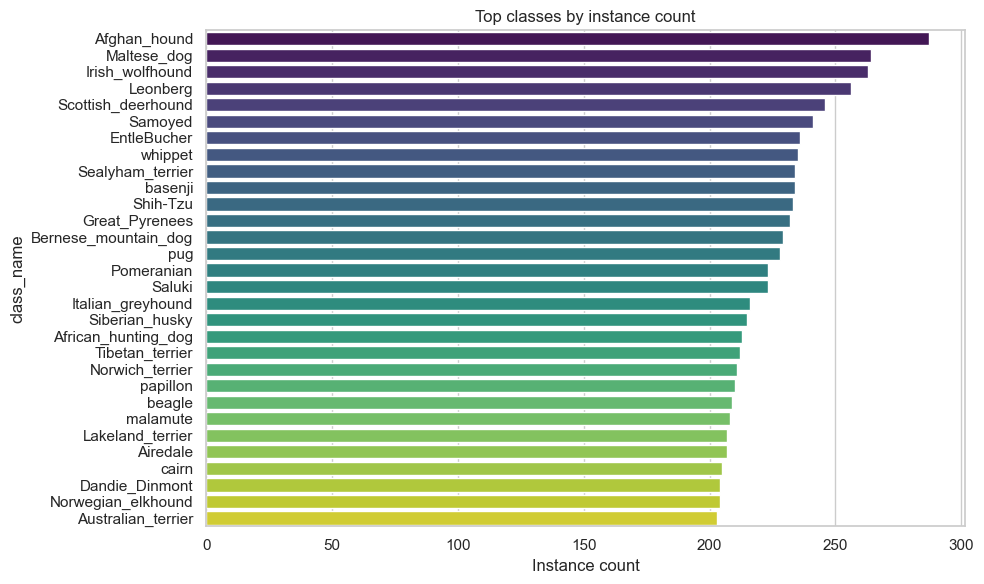

In [13]:
# Plot: class frequency top 30
plt.figure(figsize=(10, 6))
top_n = min(30, len(class_freq))
sns.barplot(x=class_freq.values[:top_n], y=class_freq.index[:top_n], palette="viridis")
plt.title("Top classes by instance count")
plt.xlabel("Instance count")
plt.tight_layout()
plt.savefig(eda_out / "class_frequency_top.png")
plt.show()
plt.close()



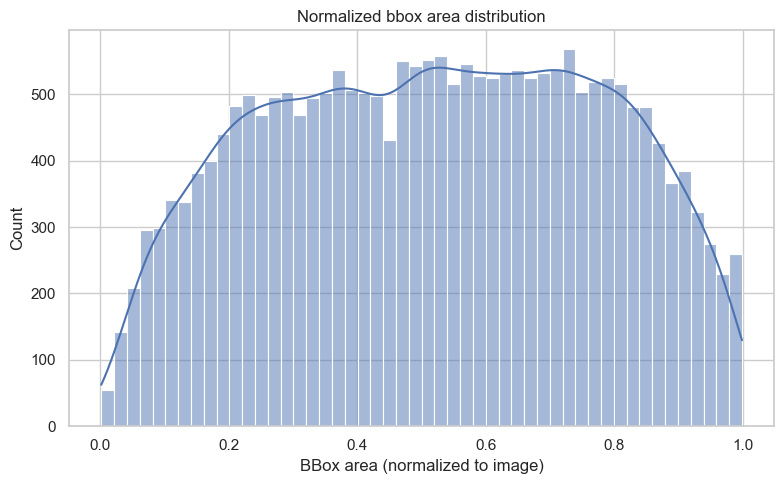

In [15]:
# BBox normalized area distribution
plt.figure()
sns.histplot(df["bbox_area_norm"].dropna(), bins=50, kde=True)
plt.title("Normalized bbox area distribution")
plt.xlabel("BBox area (normalized to image)")
plt.tight_layout()
plt.savefig(eda_out / "bbox_area_norm_hist.png")
plt.show()
plt.close()



Valid bbox_ar count: 22126


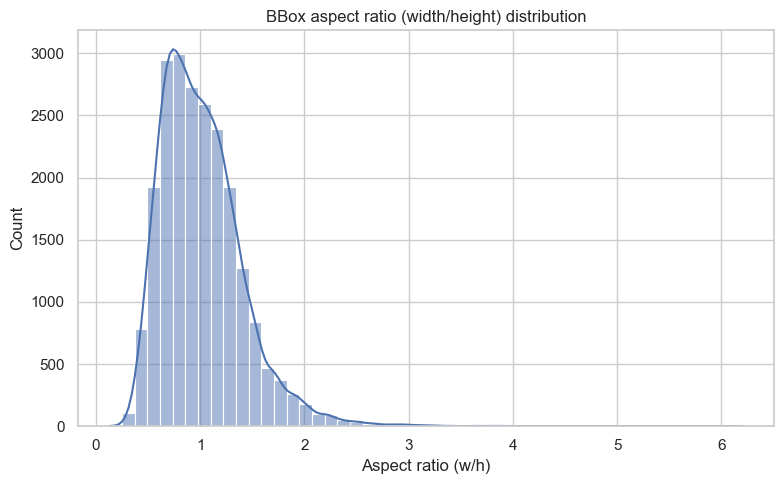

bbox_ar describe (raw):
count    22126.000000
mean         1.016407
std          0.391522
min          0.130435
25%          0.728978
50%          0.960513
75%          1.230945
max          6.200000
Name: bbox_ar, dtype: float64


In [22]:
# BBox aspect ratio distribution (robust: compute if missing, filter bad values, avoid empty plot)
import math

# Ensure bbox_ar numeric column exists; try to compute from bbox_w/bbox_h if needed
df['bbox_ar'] = pd.to_numeric(df.get('bbox_ar'), errors='coerce')
if df['bbox_ar'].isna().all():
    if ('bbox_w' in df.columns) and ('bbox_h' in df.columns):
        bw = pd.to_numeric(df['bbox_w'], errors='coerce')
        bh = pd.to_numeric(df['bbox_h'], errors='coerce')
        # avoid division by zero
        df['bbox_ar'] = bw.where(bh > 0) / bh.where(bh > 0)
    else:
        print('No bbox_ar and no bbox_w/bbox_h available to compute from.')

# Drop non-finite and extreme values
vals = df['bbox_ar'].replace([np.inf, -np.inf], np.nan).dropna().astype(float)
vals = vals[np.isfinite(vals)]

print('Valid bbox_ar count:', len(vals))
if len(vals) == 0:
    print('No valid bbox aspect ratios to plot. Check parse_xml_coordiantes and bbox fields.')
else:
    # Optionally remove extreme outliers for visibility (e.g., >100 or <0.01) while keeping full stats saved
    clip_low, clip_high = 0.01, 100.0
    vals_for_plot = vals.clip(lower=clip_low, upper=clip_high)

    plt.figure()
    sns.histplot(vals_for_plot, bins=50, kde=True)
    plt.title('BBox aspect ratio (width/height) distribution')
    plt.xlabel('Aspect ratio (w/h)')
    plt.tight_layout()
    plt.savefig(eda_out / 'bbox_aspect_ratio_hist.png')
    plt.show()
    plt.close()

    # Print some diagnostics so you can inspect raw extremes if needed
    print('bbox_ar describe (raw):')
    print(vals.describe())
    n_extreme = ((vals < clip_low) | (vals > clip_high)).sum()
    if n_extreme:
        print(f'Note: {n_extreme} extreme values were clipped for the plot (see df for raw values).')

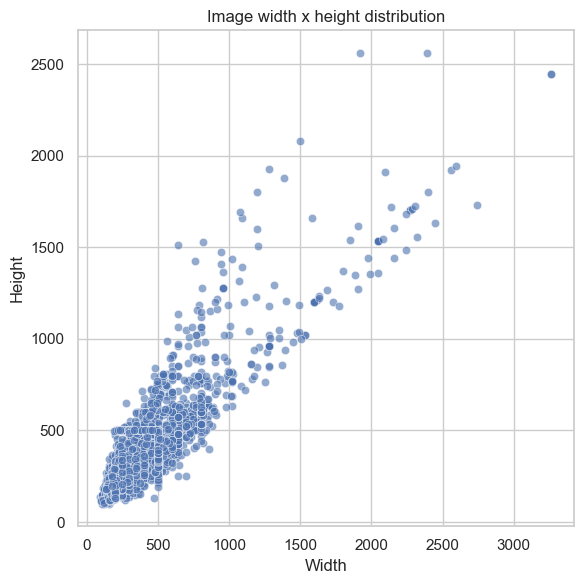

In [18]:
# Image size scatter (unique image sizes)
img_sizes = df[["image_path", "img_w", "img_h"]].drop_duplicates().dropna()
plt.figure(figsize=(6,6))
sns.scatterplot(x="img_w", y="img_h", data=img_sizes, alpha=0.6)
plt.title("Image width x height distribution")
plt.xlabel("Width")
plt.ylabel("Height")
plt.tight_layout()
plt.savefig(eda_out / "image_size_scatter.png")
plt.show()
plt.close()

# Images per class (unique images containing the class)
images_per_class = df.dropna(subset=["class_name"]).groupby("class_name")["image_path"].nunique()
images_per_class.sort_values(ascending=False).head(20).to_csv(eda_out / "images_per_class_top20.csv")


In [19]:
# Save a summary text
with open(eda_out / "summary.txt", "w") as fh:
    fh.write(f"Total unique images: {num_images}\n")
    fh.write(f"Total annotated objects: {num_annotations}\n")
    fh.write(f"Declared classes (names list length): {num_classes}\n")
    fh.write("Top 10 classes by instance count:\n")
    fh.write("\n".join([f"{i}: {c}" for i,c in enumerate(class_freq.index[:10])]) + "\n")

# Save dataframe sample and basic stats
df.describe(include="all").to_csv(eda_out / "df_describe.csv")
df.head(200).to_csv(eda_out / "annotations_sample.csv", index=False)



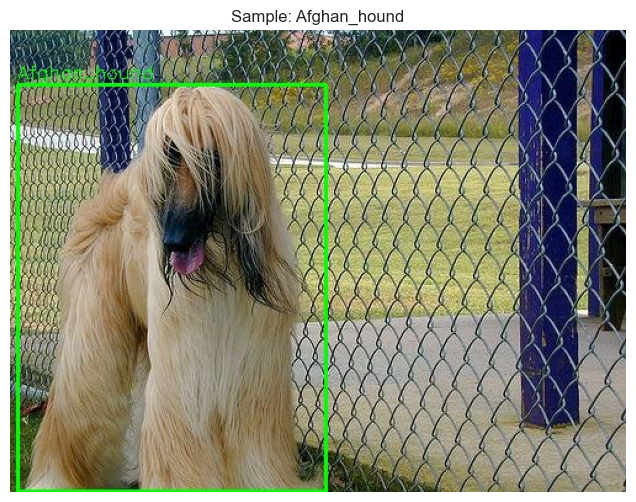

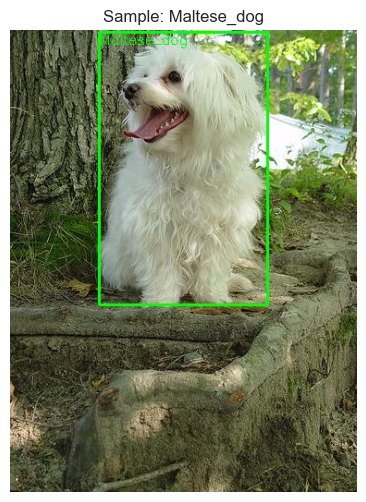

Displayed 2 sample images. EDA outputs saved to dogs_yolo_dataset/eda


In [23]:
# Create sample visualizations: for top classes, draw boxes on one image per class
def draw_boxes_on_image(image_path, ann_rows, out_path, label_col="class_name"):
    img = cv2.imread(image_path)
    if img is None:
        return
    for _, r in ann_rows.iterrows():
        if pd.isna(r["xmin"]):
            continue
        x1, y1, x2, y2 = int(r["xmin"]), int(r["ymin"]), int(r["xmax"]), int(r["ymax"])
        color = (0, 255, 0)
        cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
        label = str(r[label_col])
        cv2.putText(img, label, (x1, max(15, y1-5)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
    # save annotated image
    cv2.imwrite(str(out_path), img)

# Display only the first 2 sample images
top_classes = class_freq.index[:6]
display_limit = 2
displayed = 0
for cls in top_classes:
    if displayed >= display_limit:
        break
    subset = df[df["class_name"] == cls]
    if subset.empty:
        continue
    # pick a sample image for this class
    sample_row = subset.sample(1).iloc[0]
    img_path = sample_row["image_path"]
    ann_for_image = df[df["image_path"] == img_path]
    out_img_path = eda_out / f"sample_{cls.replace('/','_')}.jpg"
    draw_boxes_on_image(img_path, ann_for_image, out_img_path)
    # display inline: read saved image, convert BGR->RGB, and show
    disp_img = cv2.imread(str(out_img_path))
    if disp_img is not None:
        disp_img = cv2.cvtColor(disp_img, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(10, 6))
        plt.imshow(disp_img)
        plt.axis('off')
        plt.title(f"Sample: {cls}")
        plt.show()
        displayed += 1

print(f"Displayed {displayed} sample images. EDA outputs saved to {eda_out}")

#%%